In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.utils as vutils

from config import *
from models import (BaseModel, conv_block, GRelu, JRelu, Generator,
                    Discriminator)
from torch_datasets import *
from training import train
from utils import (show_batch, save_real_batch, plot_losses, show_img, 
                   show_samples, render_samples, stats)

Files already downloaded and verified


## Dataset and Data Loader

In [3]:
batch = next(iter(photo_dl))
batch[0].shape, batch[1].shape

(torch.Size([64, 3, 64, 64]), torch.Size([64]))

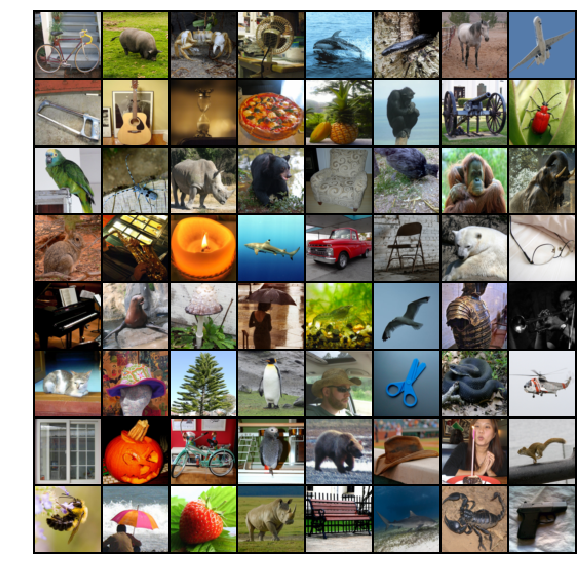

In [4]:
show_batch(photo_dl)

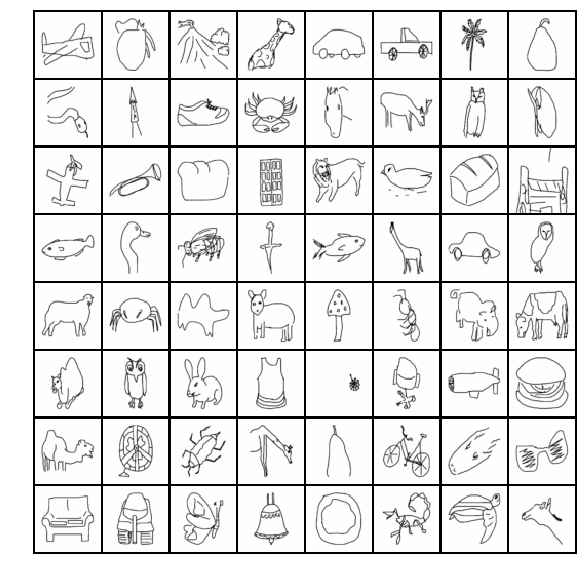

In [5]:
show_batch(sketch_dl)

## Misc Datasets

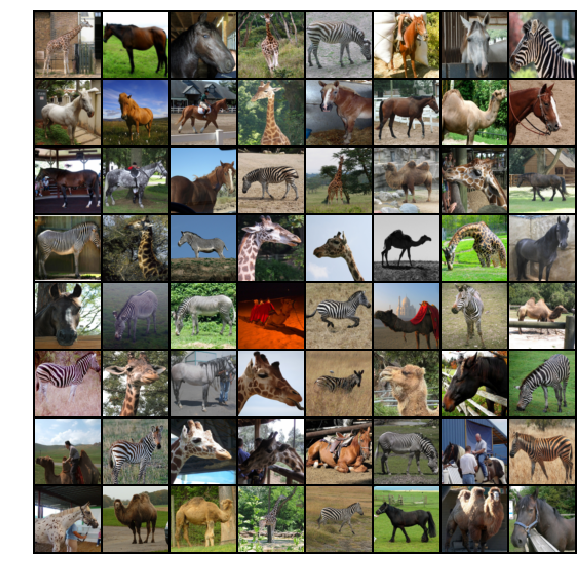

In [6]:
show_batch(small_dl)

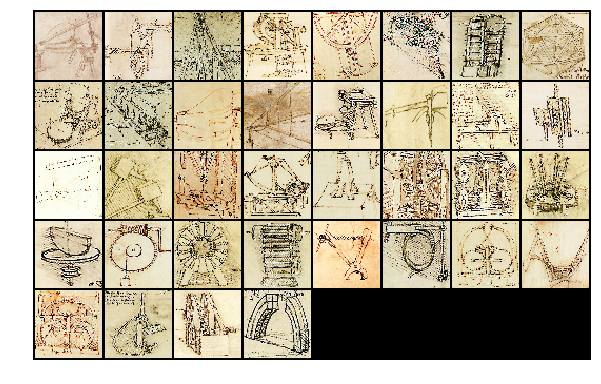

In [7]:
show_batch(dv_dl)

## Training

In [10]:
epochs = 300
output = train(epochs, photo_dl, sample_freq=10)

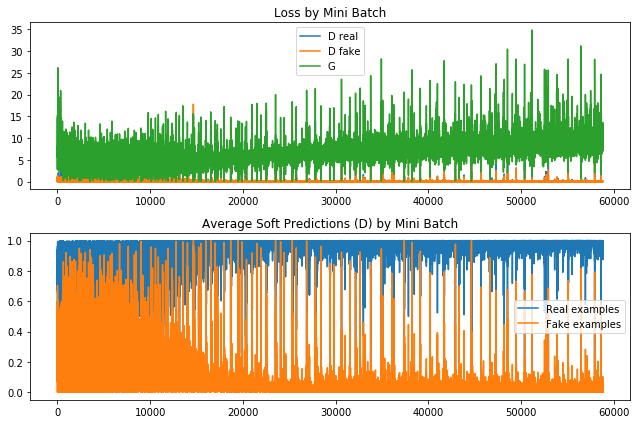

In [29]:
plot_losses(output)

In [6]:
epochs = 400
output = train(epochs, photo_dl, sample_dir='photo_samples')

In [9]:
render_samples('photo_samples', 'photos_400e.gif')

## Cifar

In [5]:
epochs = 20
cifar_output = train(epochs, cifar_dl, sample_freq=3, 
                     sample_dir='cifar_samples')

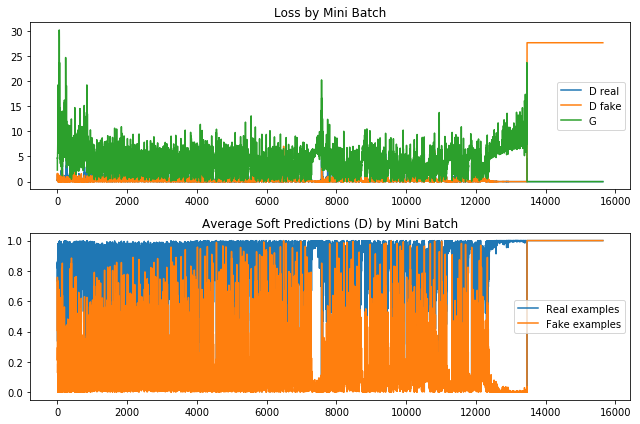

In [66]:
plot_losses(cifar_output)

In [11]:
# show_samples('cifar_samples')

## Sketches

In [4]:
epochs = 300
sketch_output = train(epochs, sketch_dl, sample_freq=10, 
                      sample_dir='sketch_samples')

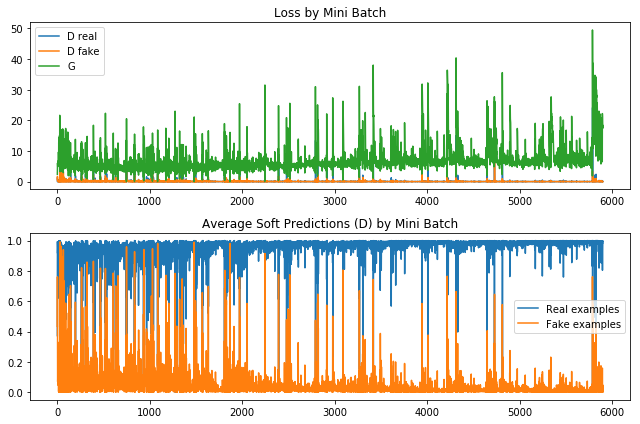

In [81]:
plot_losses(sketch_output)